### Now, define a full pipeline for calibration, wavefront detection, and then waveform inference with CNN-labeled data!

Pipeline will have the follow inputs:
1. Wavefront detection CNN training video filename, start_s, duration_s
    1. The surfspot (and registered calibration filenames in pipelines.py) is parsed from this training video filename as characters before the first _.
    1. This video is also used for labeling the training data for the CNN via waveform inference 
1. Waveform inference video filename (could be the same as 2., or any other video file from this surfspot)

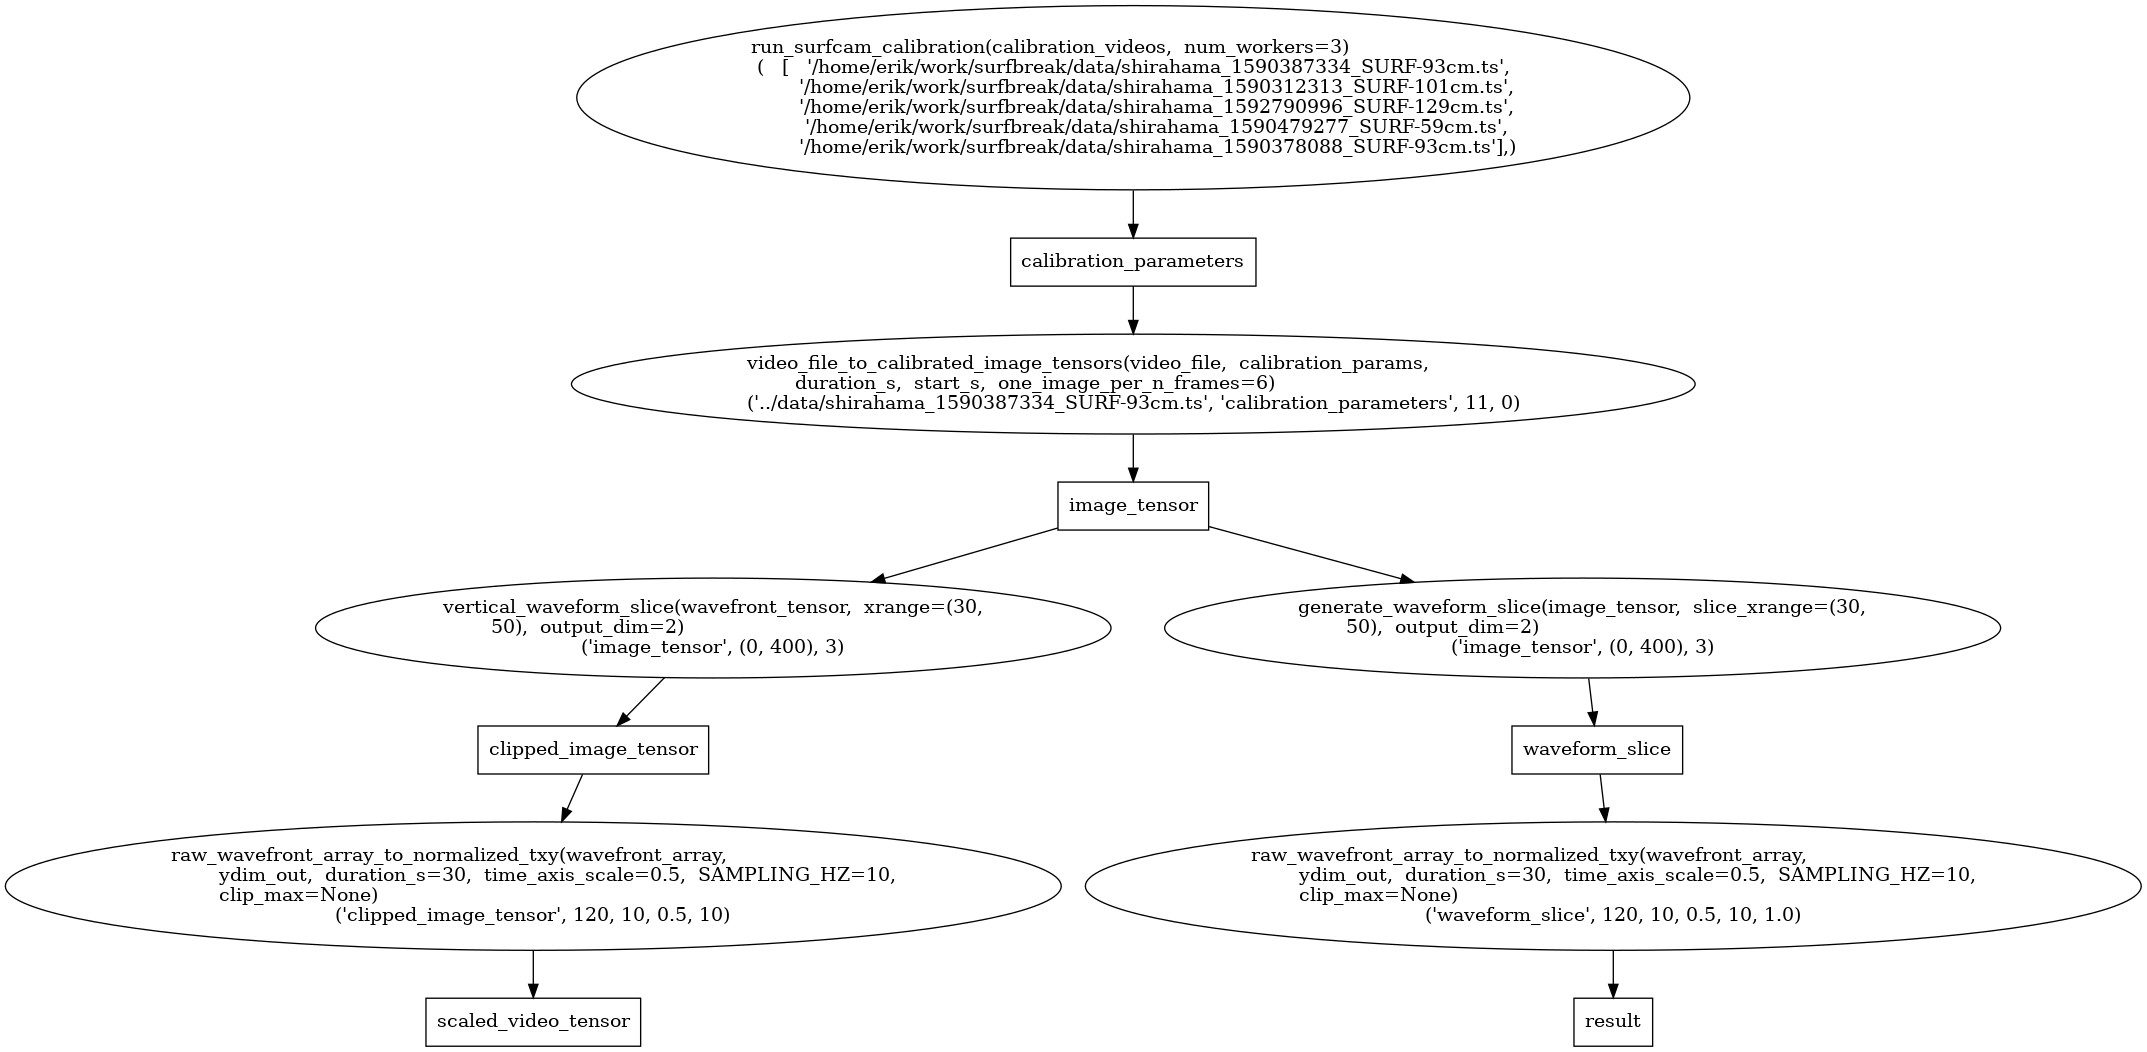

In [ ]:
# This is the calibration and rough wavefront supervision graph used for training the initial wavefront model 
# This graph is generated inside the WaveformVideoDataset class, and used to cache and output training batches
from surfbreak.pipelines import video_to_waveform_tensor
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
dask_graph = video_to_waveform_tensor(video_filepath, ydim_out=120, slice_xrange=(0,400),
                                      start_s=0, duration_s=10,  surfspot='shirahama')
from surfbreak.graphutils import visualize
visualize(dask_graph, rankdir='ud')

#### Step 1, calibrate on videos and train a waveform model with basic wavefront supervision

Now we use the graph above to train a wavefunction model on the roughly supervised wavefront signal

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet
from surfbreak.datasets import WaveformVideoDataset, WaveformChunkDataset, InferredWaveformDataset
from datetime import datetime


wf_labeling_training_video = '../data/shirahama_1590387334_SURF-93cm.ts'

def train_basic_waveform_model(training_video, max_epochs=20):
    wf_net_kwargs = dict(
        hidden_features=256,
        hidden_layers=3,
        first_omega_0=2.5,
        hidden_omega_0=11,
        squared_slowness=0.20,
        steps_per_vid_chunk=100,
        learning_rate=1e-4,
        grad_loss_scale=0,
        wavefunc_loss_scale=5.5e-9,
        wavespeed_loss_scale=4e-4, 
        xrange=(0,400),
        timerange=(0,3*30),
        chunk_duration=30,
        chunk_stride=30
    )

    wf_train_video_dataset = WaveformVideoDataset(wf_labeling_training_video, ydim=120, xrange=wf_net_kwargs['xrange'], timerange=wf_net_kwargs['timerange'], 
                                                  time_chunk_duration_s=wf_net_kwargs['chunk_duration'], time_chunk_stride_s=wf_net_kwargs['chunk_stride'], time_axis_scale=0.5)

    wavefunc_model = LitSirenNet(wf_labeling_training_video, **wf_net_kwargs, vid_dataset=wf_train_video_dataset)

    tb_logger = pl.loggers.TensorBoardLogger('logs/', name="pipeline_wf")
    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=3,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None,)

    pl.seed_everything(42)
    trainer.fit(wavefunc_model)
    
    now = datetime.now() # current date and time
    date_time = now.strftime("%m-%d-%Y_%H-%M-%S")
    checkpoint_filepath = '__graphchain_cache__/pipeline_wf_'+date_time+'.ckpt'
    trainer.save_checkpoint(checkpoint_filepath)
    
    return checkpoint_filepath

#### Now use the trained waveform model to label normalized video data, and train a CNN to directly predict the waveform signal

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN

def train_wavefront_detection_cnn(video_filepath, wf_model_checkpoint, max_epochs=20):
    pl.seed_everything(42)
                                 # Params from optimization run: fo 2.4967  ho 10.969  ss 0.20492  wfls 5.4719e-9  wsls 0.00043457
    wavecnn_model = LitWaveCNN(video_filepath=video_filepath, 
                                 wf_model_checkpoint=wf_model_checkpoint, 
                                 learning_rate=1e-4, xrange=(0,400), timerange=(0,90), chunk_duration=30, chunk_stride=30,
                                 n_input_channels=2)

    tb_logger = pl.loggers.TensorBoardLogger('logs/', name="pipeline_cnn")
    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=3,
                         max_epochs=max_epochs, 
                         gpus=1 if torch.cuda.is_available() else None,)


    trainer.fit(wavecnn_model)
    
    now = datetime.now() # current date and time
    date_time = now.strftime("%m-%d-%Y_%H-%M-%S")
    checkpoint_filepath = '__graphchain_cache__/pipeline_cnn_'+date_time+'.ckpt'
    trainer.save_checkpoint(checkpoint_filepath)
    
    return checkpoint_filepath

In [ ]:
wf_labeling_training_video

'../data/shirahama_1590387334_SURF-93cm.ts'

In [ ]:
def echo(x):
    return x
def training_pipeline(training_video):
    dask_graph = {
        'rough_waveform_model_ckpt': (train_basic_waveform_model, training_video, 20),
        'waveform_cnn_ckpt': (train_wavefront_detection_cnn, training_video, 'rough_waveform_model_ckpt', 20)
    }
    return dask_graph

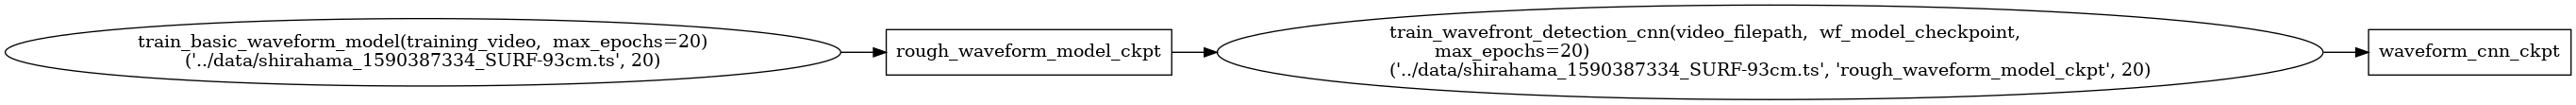

In [ ]:
wf_graph = training_pipeline(wf_labeling_training_video)
visualize(wf_graph)

In [ ]:
import graphchain
cnn_checkpoint = graphchain.get(wf_graph, 'waveform_cnn_ckpt')
cnn_checkpoint

'__graphchain_cache__/pipeline_cnn_07-08-2020_20-09-47.ckpt'

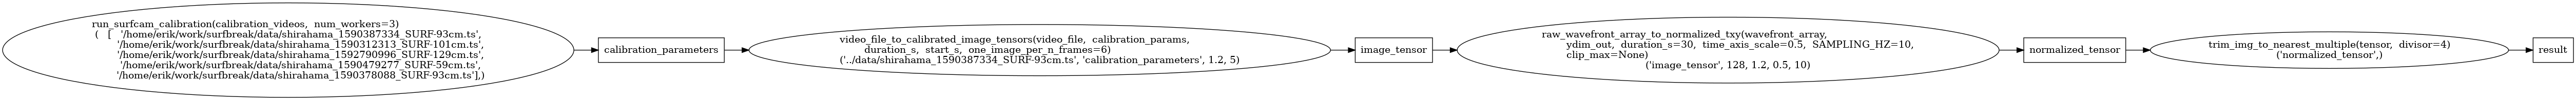

In [ ]:
from surfbreak.pipelines import video_to_trimmed_tensor
wf_graph = video_to_trimmed_tensor(wf_labeling_training_video, start_s=5, duration_s=1.2, time_axis_scale=0.5)
visualize(wf_graph)

(6, 1312, 128)


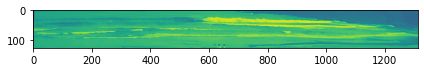

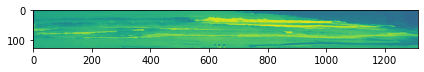

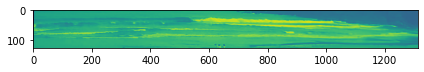

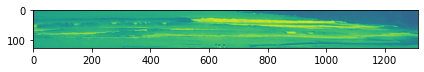

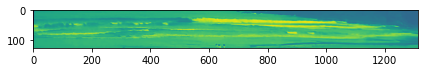

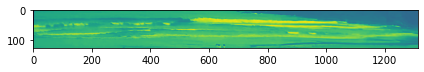

In [ ]:
import matplotlib.pyplot as plt
trimmed_tensor = graphchain.get(wf_graph, 'result')
print(trimmed_tensor.shape)
for t in range(trimmed_tensor.shape[0]):
    plt.imshow(trimmed_tensor[t].T)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
def detect_wavefronts(wf_cnn_checkpoint, video_tensor):
    wavecnn_model = LitWaveCNN.load_from_checkpoint(wf_cnn_checkpoint)
    # Append the second channel with time-delta intensity
    input_img_array_tcxy = np.concatenate((video_tensor[:-1][None,...], 
                                          video_tensor[1:][None,...] - video_tensor[:-1][None,...]), axis=0).transpose(1,0,2,3)
    return wavecnn_model(torch.from_numpy(input_img_array_tcxy))
    

In [ ]:
inferred_wf_tensor = detect_wavefronts(cnn_checkpoint, trimmed_tensor)
inferred_wf_tensor.shape

torch.Size([5, 1, 1312, 128])

In [ ]:
from torch.utils.data import Dataset
from surfbreak.pipelines import video_to_trimmed_tensor
from surfbreak.datasets import video_txy_to_wavecnn_array_cxy, get_mgrid

def get_trimmed_tensor(wf_labeling_training_video, start_s=5, duration_s=1.2, time_axis_scale=0.5):
    wf_graph = video_to_trimmed_tensor(wf_labeling_training_video, start_s=start_s, duration_s=duration_s, time_axis_scale=time_axis_scale)
    return graphchain.get(wf_graph, 'result')


class CNNChunkDataset(Dataset):
    def __init__(self, video_filepath, wavecnn_ckpt, ydim=150, timerange=(0,61), time_chunk_duration_s=1, time_chunk_stride_s=1, time_axis_scale=0.5):
        super().__init__()
        self.video_filepath = video_filepath
        self.wavecnn_ckpt = wavecnn_ckpt
        self.ydim = ydim
        self.time_axis_scale = time_axis_scale
        self.time_chunk_duration_s = time_chunk_duration_s
        self.time_chunk_stride_s = time_chunk_stride_s
        self.t_coords_per_second = 10 * time_axis_scale
        self.average_wavefront_xy = 0

        start_s, end_s = timerange
        self.video_chunk_timeranges = np.array(list((start, start+time_chunk_duration_s) for start in
                                                    range(start_s, end_s + 1 - time_chunk_duration_s, time_chunk_stride_s)))
        item_start_s, item_end_s = self.video_chunk_timeranges[0]
        self.first_raw_vid_tensor = get_trimmed_tensor(self.video_filepath, start_s=item_start_s, duration_s=(item_end_s - item_start_s),
                                                       time_axis_scale=self.time_axis_scale)
        self.wavecnn_model = LitWaveCNN.load_from_checkpoint(wavecnn_ckpt, wf_model_checkpoint=None).cuda()
        
        firstout, firstgt = self[0]
        acc_wf_img = np.zeros_like(firstgt['wavefronts_txy'].mean(axis=0))
        for model_in, model_gt in self:
            acc_wf_img += model_gt['wavefronts_txy'].mean(axis=0)
        avg_wf_img = acc_wf_img / len(self)
        self.average_wavefront_xy = avg_wf_img
        
    def __len__(self):
        return len(self.video_chunk_timeranges)

    def __getitem__(self, idx):
        item_start_s, item_end_s = self.video_chunk_timeranges[idx]
        vid_tensor_tplus1 = get_trimmed_tensor(self.video_filepath, start_s=item_start_s, 
                                               duration_s=(item_end_s - item_start_s + 1/self.t_coords_per_second), # Add one extra timestep here
                                               time_axis_scale=self.time_axis_scale)

        wavecnn_input_tcxy = np.concatenate((vid_tensor_tplus1[:-1][None,...],  # Get a 2-channel representation (intensity, timedelta)
                                      vid_tensor_tplus1[1:][None,...] - vid_tensor_tplus1[:-1][None,...]), axis=0).transpose(1,0,2,3)
        vid_tensor_txy = vid_tensor_tplus1[:-1] # Remove the extra timestep which was needed for the wavecnn input calculation
        assert wavecnn_input_tcxy.shape[0] == vid_tensor_txy.shape[0] # Ensure length of time dimension is identical
        # Process the input video tensors one timestep at a time on the GPU, to avoid using too much memory
        frames_out = []
        for t in range(wavecnn_input_tcxy.shape[0]):
            this_wavecnn_input = torch.from_numpy(wavecnn_input_tcxy[t]).cuda()[None,...]
            frames_out.append(self.wavecnn_model(this_wavecnn_input)[:,0].detach().cpu().numpy()) # Remove the empty second channel dimension
        wavecnn_label = np.concatenate(frames_out, axis=0)

        # For now, abstract time coordinates will be in centered minutes (so a 2 minute video spans -1 to 1, and a 30 minute video spans -15 to 15)
        full_duration_s = self.video_chunk_timeranges.max() - self.video_chunk_timeranges.min()
        full_tcoord_range = -((full_duration_s/60) / 2), ((full_duration_s/60) / 2)

        this_chunk_tcoord_range = [self.video_chunk_timeranges[idx][0]/60 - full_tcoord_range[1],
                                   self.video_chunk_timeranges[idx][1]/60 - full_tcoord_range[1]]

        all_coords = get_mgrid(vid_tensor_txy.shape, tcoord_range=this_chunk_tcoord_range)

        model_input = {
            'coords_txyc':all_coords.reshape(*vid_tensor_txy.shape,3)
        }

        assert vid_tensor_txy.shape == wavecnn_label.shape
        ground_truth = {
            "video_txy": vid_tensor_txy,
            "wavefronts_txy": wavecnn_label - self.average_wavefront_xy,
            "timerange": (item_start_s, item_end_s),
        }

        return model_input, ground_truth

In [ ]:
input_video = '../data/shirahama_1590387334_SURF-93cm.ts'
CNND = CNNChunkDataset(input_video, cnn_checkpoint, time_chunk_duration_s=10, time_chunk_stride_s=10, timerange=(0,60))
print(CNND.video_chunk_timeranges)
model_in, model_gt = CNND[0]
print(model_in['coords_txyc'].shape, model_gt['video_txy'].shape, model_gt['wavefronts_txy'].shape)

[[ 0 10]
 [10 20]
 [20 30]
 [30 40]
 [40 50]
 [50 60]]
torch.Size([50, 1312, 128, 3]) (50, 1312, 128) (50, 1312, 128)


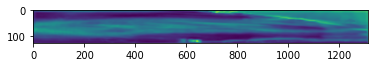

In [ ]:
plt.imshow(CNND.average_wavefront_xy.T)

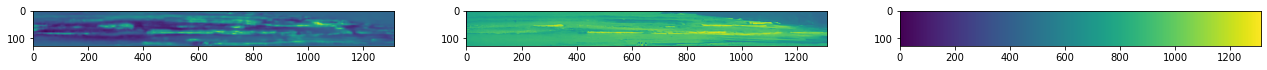

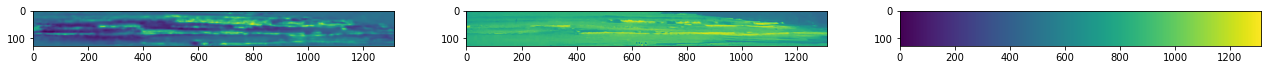

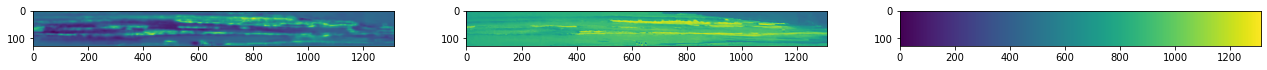

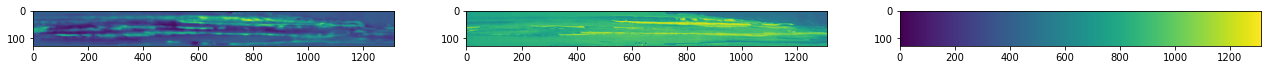

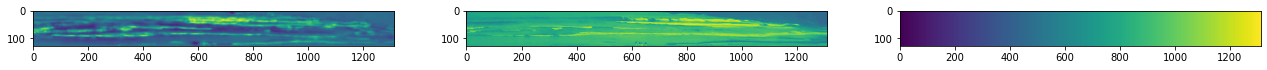

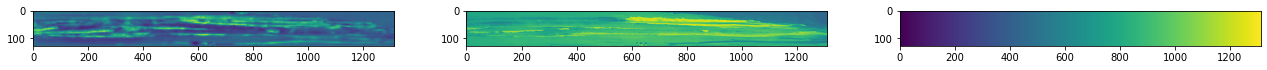

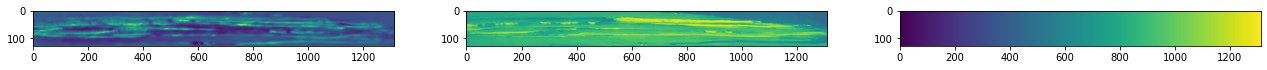

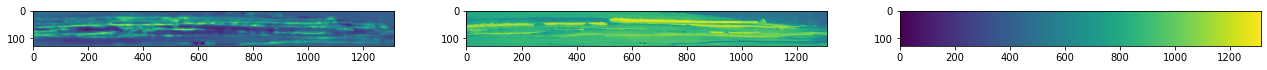

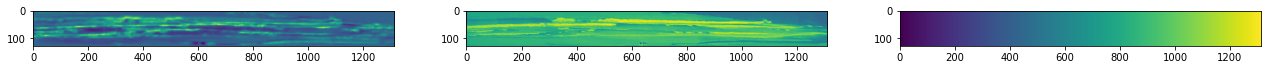

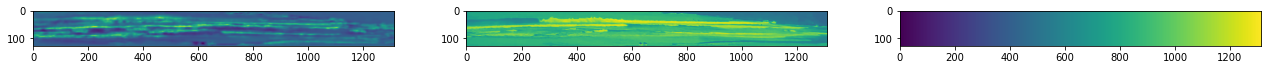

In [ ]:
model_in, model_gt = CNND[0]
for t in range(0,model_gt['wavefronts_txy'].shape[0],5):
    fig, axes = plt.subplots(ncols=3, figsize=(22,2))
    axes[0].imshow(model_gt['wavefronts_txy'][t].T)# - CNND.average_wavefront_xy.T)
    axes[1].imshow(model_gt['video_txy'][t].T)
    axes[2].imshow(model_in['coords_txyc'][t,:,:,1].T) # Display the X coordinates